In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

In [39]:
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])
    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [40]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [41]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [42]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [43]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [44]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [45]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [46]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=0,
    inter_op_parallelism_threads=0
)

In [47]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [48]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [49]:
# Initializing parameters
epochs = 30
batch_size = 16

In [50]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [51]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

C:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [52]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [53]:
def plot_confusion_matrix_lstm(Y_test,Y_pred):
    result= confusion_matrix(Y_test,Y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(result, xticklabels= list(ACTIVITIES.values()), yticklabels=list(ACTIVITIES.values()), annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    

# Plot train and cross validation loss
def plot_train_cv_loss(trained_model, epochs, colors=['b']):
    fig, ax = plt.subplots(1,1)    
    ax.set_xlabel('epoch') 
    ax.set_ylabel('Categorical Crossentropy Loss')
    x_axis_values = list(range(1,epochs+1))

    validation_loss = trained_model.history['val_loss']
    train_loss = trained_model.history['loss']   
    
    ax.plot(x_axis_values, validation_loss, 'b', label="Validation Loss")
    ax.plot(x_axis_values, train_loss, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

## 2 Layer LSTM with 32 initial nodes, Dropout Rate=0.5 and Sigmoid Activation

In [18]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(32, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

In [20]:
# Training the model
trained_model=model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test), epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 23s 3ms/step - loss: 1.3220 - acc: 0.4429 - val_loss: 1.1422 - val_acc: 0.4818
Epoch 2/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.9893 - acc: 0.5756 - val_loss: 0.9340 - val_acc: 0.5952
Epoch 3/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.8000 - acc: 0.6454 - val_loss: 0.7747 - val_acc: 0.6172
Epoch 4/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.7035 - acc: 0.6576 - val_loss: 0.7739 - val_acc: 0.6071
Epoch 5/30
7352/7352 [==============================] - 23s 3ms/step - loss: 0.7130 - acc: 0.6498 - val_loss: 0.8609 - val_acc: 0.6166
Epoch 6/30
7352/7352 [==============================] - 25s 3ms/step - loss: 0.6324 - acc: 0.6723 - val_loss: 0.7560 - val_acc: 0.6169
Epoch 7/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.6098 - acc: 0.6

In [21]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 338us/step


In [22]:
score

[0.5264192177435539, 0.8808958262639973]

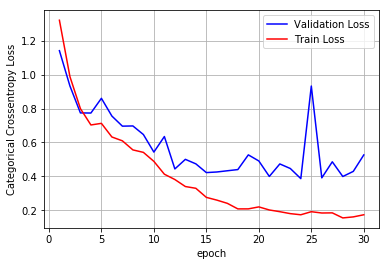

In [23]:
plot_train_cv_loss(trained_model, epochs)

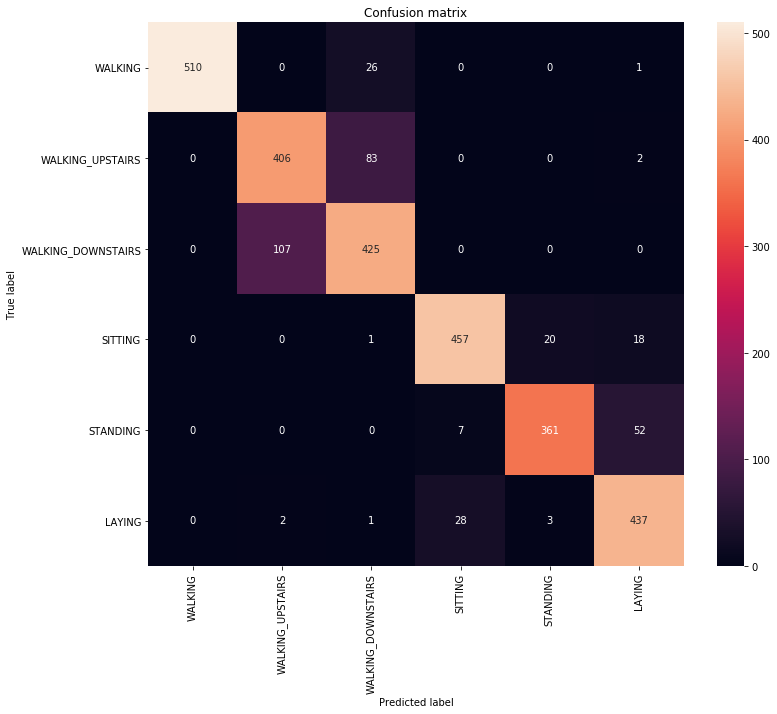

In [26]:
plot_confusion_matrix_lstm(Y_test, model.predict(X_test))

## 2 Layer LSTM with 32 initial nodes, Dropout Rate=0.5 and Softmax Activation

In [28]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(32, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

In [30]:
# Training the model
trained_model=model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test), epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 24s 3ms/step - loss: 1.2011 - acc: 0.4971 - val_loss: 1.2821 - val_acc: 0.5042
Epoch 2/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.7713 - acc: 0.6760 - val_loss: 0.7063 - val_acc: 0.7177
Epoch 3/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.5920 - acc: 0.7900 - val_loss: 0.7160 - val_acc: 0.7122
Epoch 4/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.4718 - acc: 0.8474 - val_loss: 0.4406 - val_acc: 0.8517
Epoch 5/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.3907 - acc: 0.8815 - val_loss: 0.4106 - val_acc: 0.8622
Epoch 6/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.3108 - acc: 0.9055 - val_loss: 0.3661 - val_acc: 0.8884
Epoch 7/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.2812 - acc: 0.9131 - val_loss: 0.3446 - val_acc: 0.8907
Epoch 8

In [31]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 345us/step


In [32]:
score

[0.3734870147556876, 0.9036308109942314]

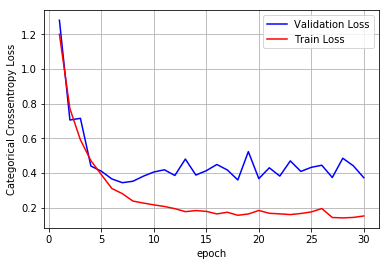

In [33]:
plot_train_cv_loss(trained_model, epochs)

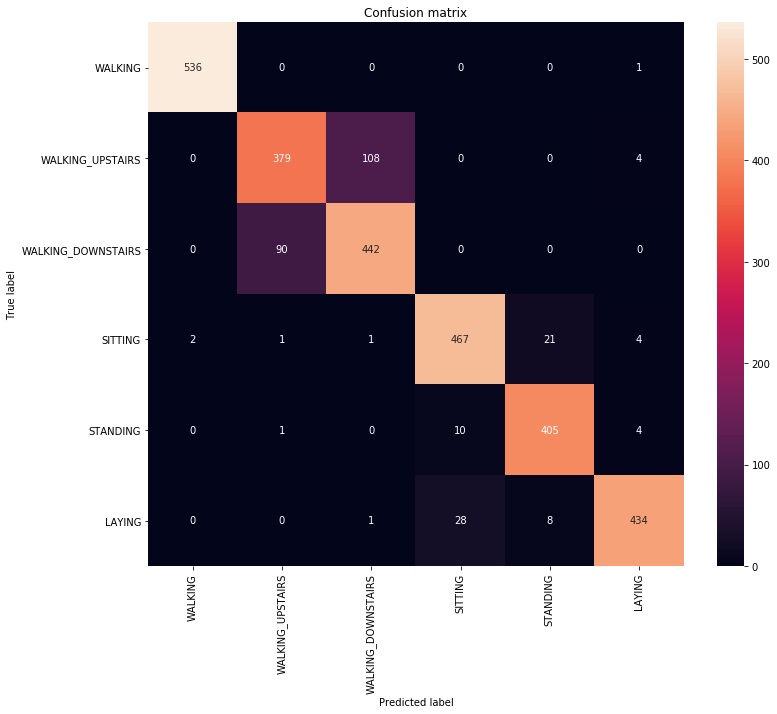

In [34]:
plot_confusion_matrix_lstm(Y_test, model.predict(X_test))

## 2 Layer LSTM with 32 initial nodes, Dropout Rate=0.7 and Softmax Activation

In [35]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(32, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

In [37]:
# Training the model
trained_model=model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test), epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 23s 3ms/step - loss: 1.3151 - acc: 0.4395 - val_loss: 1.1416 - val_acc: 0.5531
Epoch 2/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.9598 - acc: 0.5951 - val_loss: 0.8264 - val_acc: 0.6624
Epoch 3/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.8507 - acc: 0.6421 - val_loss: 0.7263 - val_acc: 0.7092
Epoch 4/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.6569 - acc: 0.7288 - val_loss: 0.6883 - val_acc: 0.7540
Epoch 5/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.5747 - acc: 0.7952 - val_loss: 0.7996 - val_acc: 0.7384
Epoch 6/30
7352/7352 [==============================] - 21s 3ms/step - loss: 0.5092 - acc: 0.8388 - val_loss: 0.5551 - val_acc: 0.8117
Epoch 7/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.4275 - acc: 0.8719 - val_loss: 0.4646 - val_acc: 0.8453
Epoch 8

In [38]:
score=model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 340us/step


In [39]:
score

[0.3170517044905194, 0.9141499830335935]

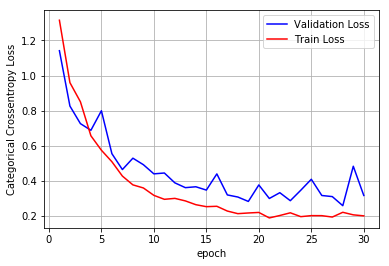

In [40]:
plot_train_cv_loss(trained_model, epochs)

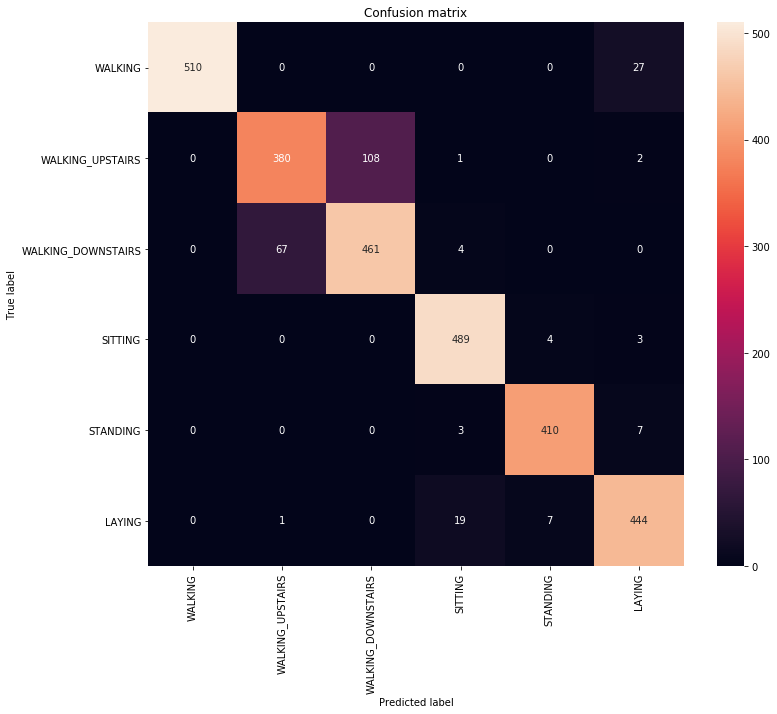

In [41]:
plot_confusion_matrix_lstm(Y_test, model.predict(X_test))

## 2 Layer LSTM with 64 initial nodes, Dropout Rate=0.5 and Softmax Activation

In [42]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(64, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

In [44]:
# Training the model
trained_model=model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test), epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 25s 3ms/step - loss: 1.0639 - acc: 0.5517 - val_loss: 0.8051 - val_acc: 0.6966
Epoch 2/30
7352/7352 [==============================] - 24s 3ms/step - loss: 0.6143 - acc: 0.7680 - val_loss: 0.6863 - val_acc: 0.7218
Epoch 3/30
7352/7352 [==============================] - 24s 3ms/step - loss: 0.3717 - acc: 0.8788 - val_loss: 0.7644 - val_acc: 0.7849
Epoch 4/30
7352/7352 [==============================] - 24s 3ms/step - loss: 0.2606 - acc: 0.9144 - val_loss: 0.3574 - val_acc: 0.8782
Epoch 5/30
7352/7352 [==============================] - 24s 3ms/step - loss: 0.2235 - acc: 0.9261 - val_loss: 0.3239 - val_acc: 0.8829
Epoch 6/30
7352/7352 [==============================] - 24s 3ms/step - loss: 0.2018 - acc: 0.9325 - val_loss: 0.4776 - val_acc: 0.8795
Epoch 7/30
7352/7352 [==============================] - 24s 3ms/step - loss: 0.1927 - acc: 0.9373 - val_loss: 0.4192 - val_acc: 0.8962
Epoch 8

In [45]:
score=model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 440us/step


In [46]:
score

[0.32685461992340153, 0.9192399049881235]

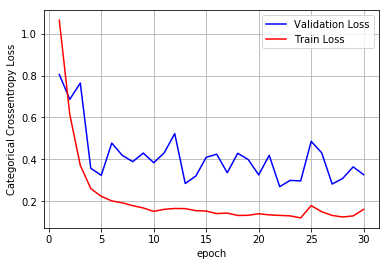

In [47]:
plot_train_cv_loss(trained_model, epochs)

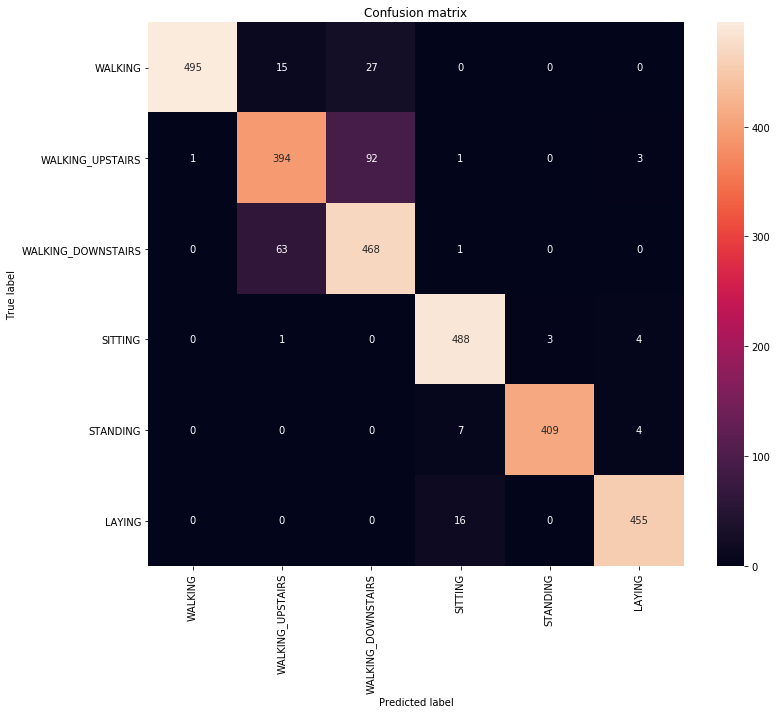

In [48]:
plot_confusion_matrix_lstm(Y_test, model.predict(X_test))

## 2 Layer LSTM with 64 initial nodes, Dropout Rate=0.7 and Softmax Activation

In [49]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(64, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

In [51]:
# Training the model
trained_model=model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test), epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 26s 4ms/step - loss: 1.1118 - acc: 0.5242 - val_loss: 0.8374 - val_acc: 0.6481
Epoch 2/30
7352/7352 [==============================] - 24s 3ms/step - loss: 0.6433 - acc: 0.7163 - val_loss: 0.6106 - val_acc: 0.7703
Epoch 3/30
7352/7352 [==============================] - 25s 3ms/step - loss: 0.4947 - acc: 0.8288 - val_loss: 0.6445 - val_acc: 0.7452
Epoch 4/30
7352/7352 [==============================] - 24s 3ms/step - loss: 0.3747 - acc: 0.8833 - val_loss: 0.3573 - val_acc: 0.8721
Epoch 5/30
7352/7352 [==============================] - 25s 3ms/step - loss: 0.2724 - acc: 0.9135 - val_loss: 0.6264 - val_acc: 0.8354
Epoch 6/30
7352/7352 [==============================] - 24s 3ms/step - loss: 0.2383 - acc: 0.9203 - val_loss: 0.3728 - val_acc: 0.8812
Epoch 7/30
7352/7352 [==============================] - 25s 3ms/step - loss: 0.1952 - acc: 0.9291 - val_loss: 0.4349 - val_acc: 0.8829
Epoch 8

In [52]:
score=model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 445us/step


In [53]:
score

[0.34648106429007025, 0.9107567017305734]

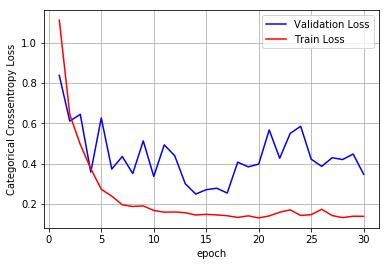

In [54]:
plot_train_cv_loss(trained_model, epochs)

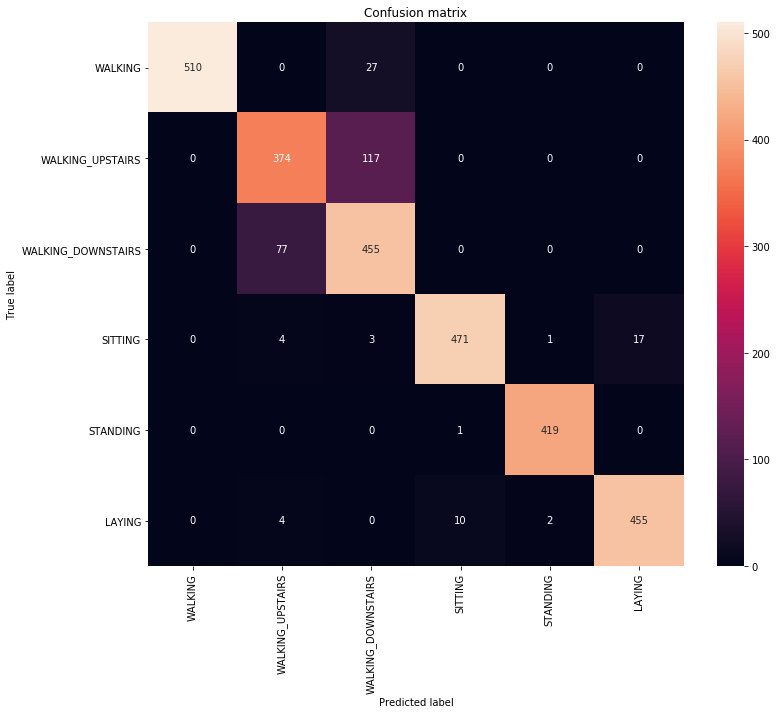

In [55]:
plot_confusion_matrix_lstm(Y_test, model.predict(X_test))

## 3 Layer LSTM with 32 nodes, Dropout Rate=0.5 and Softmax Activation

In [56]:
# Initiliazing the sequential model
from keras.layers.normalization import BatchNormalization
model = Sequential()
model.add(LSTM(32, input_shape=(timesteps, input_dim), return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(LSTM(16))
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(Dense(n_classes, activation='softmax'))
print("Model Summary: ")
model.summary()

Model Summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 32)           128       
_________________________________________________________________
dropout_6 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 16)                3136      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 102  

In [57]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

In [58]:
# Training the model
trained_model=model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test), epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 50s 7ms/step - loss: 1.1452 - acc: 0.5680 - val_loss: 0.6718 - val_acc: 0.7452
Epoch 2/30
7352/7352 [==============================] - 45s 6ms/step - loss: 0.7271 - acc: 0.7146 - val_loss: 0.4765 - val_acc: 0.8324
Epoch 3/30
7352/7352 [==============================] - 45s 6ms/step - loss: 0.5219 - acc: 0.8176 - val_loss: 0.3329 - val_acc: 0.8795
Epoch 4/30
7352/7352 [==============================] - 45s 6ms/step - loss: 0.4978 - acc: 0.8372 - val_loss: 2.6116 - val_acc: 0.4608
Epoch 5/30
7352/7352 [==============================] - 45s 6ms/step - loss: 0.3952 - acc: 0.8694 - val_loss: 0.2567 - val_acc: 0.9009
Epoch 6/30
7352/7352 [==============================] - 45s 6ms/step - loss: 0.3022 - acc: 0.9056 - val_loss: 0.2670 - val_acc: 0.9118
Epoch 7/30
7352/7352 [==============================] - 45s 6ms/step - loss: 0.2972 - acc: 0.9033 - val_loss: 0.2502 - val_acc: 0.9141
Epoch 8

In [59]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 2s 687us/step


In [60]:
score

[0.6117659829870041, 0.8971835765184933]

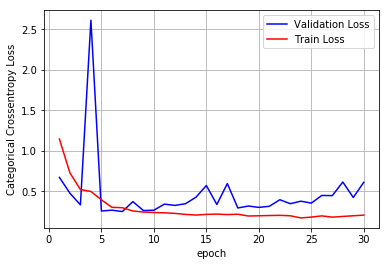

In [61]:
plot_train_cv_loss(trained_model, epochs)

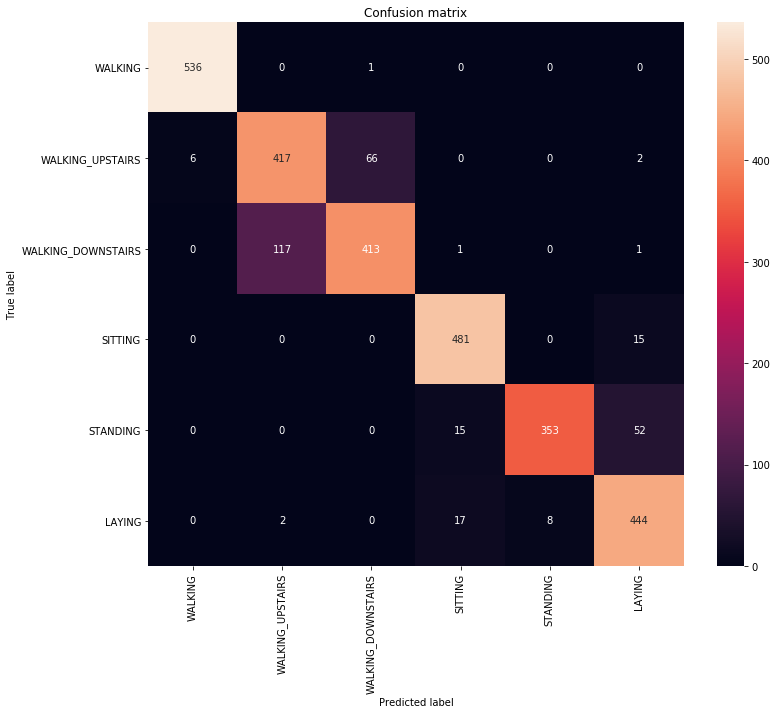

In [62]:
plot_confusion_matrix_lstm(Y_test, model.predict(X_test))

## 3 Layer LSTM with 32 nodes, Batch Normalization, Dropout Rate=0.7 and Softmax Activation

In [63]:
# Initiliazing the sequential model
from keras.layers.normalization import BatchNormalization
model = Sequential()
model.add(LSTM(32, input_shape=(timesteps, input_dim), return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.70))
model.add(LSTM(16))
model.add(BatchNormalization())
model.add(Dropout(0.70))
model.add(Dense(n_classes, activation='softmax'))
print("Model Summary: ")
model.summary()

Model Summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 32)           128       
_________________________________________________________________
dropout_8 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 16)                3136      
_________________________________________________________________
batch_normalization_4 (Batch (None, 16)                64        
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 102  

In [64]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

In [65]:
# Training the model
trained_model=model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test), epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 48s 7ms/step - loss: 1.5142 - acc: 0.4444 - val_loss: 0.8378 - val_acc: 0.5898
Epoch 2/30
7352/7352 [==============================] - 45s 6ms/step - loss: 0.9716 - acc: 0.5754 - val_loss: 0.8067 - val_acc: 0.6369
Epoch 3/30
7352/7352 [==============================] - 45s 6ms/step - loss: 0.8628 - acc: 0.6126 - val_loss: 1.4182 - val_acc: 0.6084
Epoch 4/30
7352/7352 [==============================] - 46s 6ms/step - loss: 0.7961 - acc: 0.6519 - val_loss: 0.7745 - val_acc: 0.7370
Epoch 5/30
7352/7352 [==============================] - 46s 6ms/step - loss: 0.7145 - acc: 0.6923 - val_loss: 1.0265 - val_acc: 0.7214
Epoch 6/30
7352/7352 [==============================] - 45s 6ms/step - loss: 0.6573 - acc: 0.7172 - val_loss: 2.1467 - val_acc: 0.5487
Epoch 7/30
7352/7352 [==============================] - 46s 6ms/step - loss: 0.7669 - acc: 0.6782 - val_loss: 0.5579 - val_acc: 0.7716
Epoch 8

In [66]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 2s 757us/step


In [67]:
score

[0.5351267743307431, 0.9056667797760435]

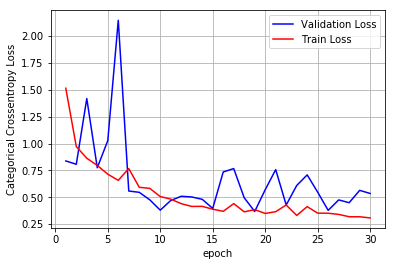

In [68]:
plot_train_cv_loss(trained_model, epochs)

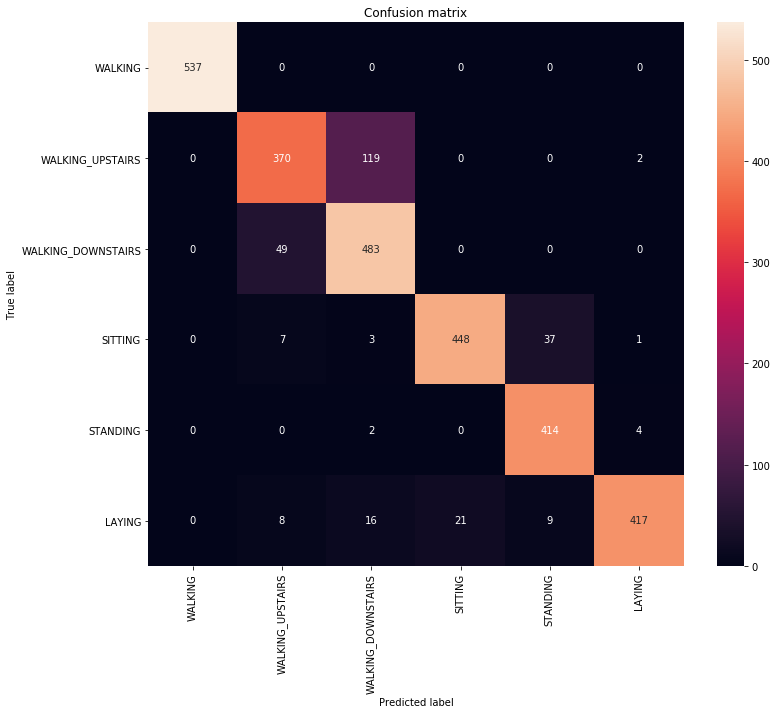

In [69]:
plot_confusion_matrix_lstm(Y_test, model.predict(X_test))

## 3 Layer LSTM with 64 initial nodes, Batch Normalization, Dropout Rate= 0.5 and SoftMax Activation

In [18]:
# Initiliazing the sequential model
from keras.layers.normalization import BatchNormalization
model = Sequential()
model.add(LSTM(64, input_shape=(timesteps, input_dim), return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(LSTM(16))
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(Dense(n_classes, activation='softmax'))
print("Model Summary: ")
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model Summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 64)           256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                5184      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
dropo

In [19]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

In [20]:
# Training the model
trained_model=model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test), epochs=epochs)

Instructions for updating:
Use tf.cast instead.
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 54s 7ms/step - loss: 1.1240 - acc: 0.5846 - val_loss: 0.8250 - val_acc: 0.6800
Epoch 2/30
7352/7352 [==============================] - 49s 7ms/step - loss: 0.6637 - acc: 0.7546 - val_loss: 0.5599 - val_acc: 0.8086
Epoch 3/30
7352/7352 [==============================] - 48s 7ms/step - loss: 0.4686 - acc: 0.8409 - val_loss: 0.4272 - val_acc: 0.8575
Epoch 4/30
7352/7352 [==============================] - 48s 7ms/step - loss: 0.3774 - acc: 0.8760 - val_loss: 0.4290 - val_acc: 0.8721
Epoch 5/30
7352/7352 [==============================] - 48s 7ms/step - loss: 0.3261 - acc: 0.8943 - val_loss: 0.4083 - val_acc: 0.8466
Epoch 6/30
7352/7352 [==============================] - 48s 7ms/step - loss: 0.2834 - acc: 0.9061 - val_loss: 0.6971 - val_acc: 0.8083
Epoch 7/30
7352/7352 [==============================] - 49s 7ms/step - loss: 0.2723 - acc: 0.9

In [21]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 2s 847us/step


In [22]:
score

[0.306039857633167, 0.9182219205972175]

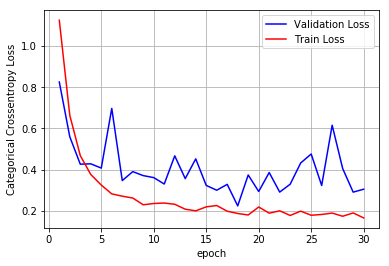

In [23]:
plot_train_cv_loss(trained_model, epochs)

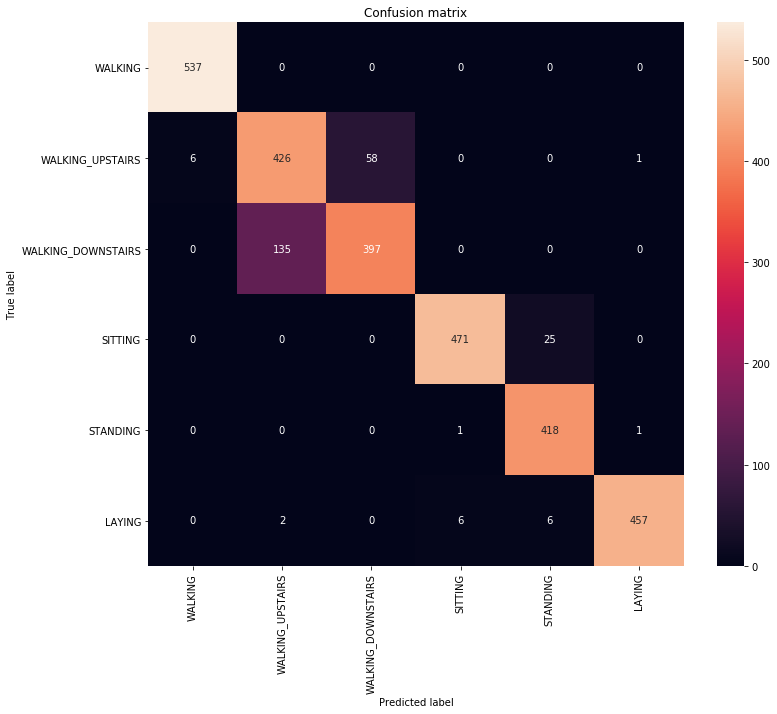

In [24]:
plot_confusion_matrix_lstm(Y_test, model.predict(X_test))

## 3 Layer LSTM with 64 initial nodes, Batch Normalization, Dropout Rate= 0.7 and SoftMax Activation

In [25]:
# Initiliazing the sequential model
from keras.layers.normalization import BatchNormalization
model = Sequential()
model.add(LSTM(64, input_shape=(timesteps, input_dim), return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.70))
model.add(LSTM(16))
model.add(BatchNormalization())
model.add(Dropout(0.70))
model.add(Dense(n_classes, activation='softmax'))
print("Model Summary: ")
model.summary()

Model Summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 64)           256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 16)                5184      
_________________________________________________________________
batch_normalization_4 (Batch (None, 16)                64        
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 102  

In [26]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

In [27]:
# Training the model
trained_model=model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test), epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 50s 7ms/step - loss: 1.4479 - acc: 0.4550 - val_loss: 0.8785 - val_acc: 0.6393
Epoch 2/30
7352/7352 [==============================] - 48s 7ms/step - loss: 1.0597 - acc: 0.5628 - val_loss: 1.1372 - val_acc: 0.5148
Epoch 3/30
7352/7352 [==============================] - 48s 7ms/step - loss: 0.9048 - acc: 0.6183 - val_loss: 0.6239 - val_acc: 0.8113
Epoch 4/30
7352/7352 [==============================] - 48s 7ms/step - loss: 0.8025 - acc: 0.6586 - val_loss: 0.4615 - val_acc: 0.8497
Epoch 5/30
7352/7352 [==============================] - 48s 7ms/step - loss: 0.6851 - acc: 0.7178 - val_loss: 0.3866 - val_acc: 0.8826
Epoch 6/30
7352/7352 [==============================] - 48s 7ms/step - loss: 0.6110 - acc: 0.7602 - val_loss: 0.4472 - val_acc: 0.8269
Epoch 7/30
7352/7352 [==============================] - 48s 7ms/step - loss: 0.5482 - acc: 0.7798 - val_loss: 0.4378 - val_acc: 0.8371
Epoch 8

In [28]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 3s 868us/step


In [29]:
score

[0.3366689515527395, 0.9131319986426875]

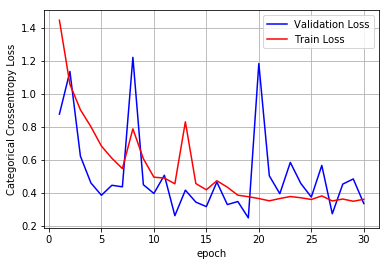

In [30]:
plot_train_cv_loss(trained_model, epochs)

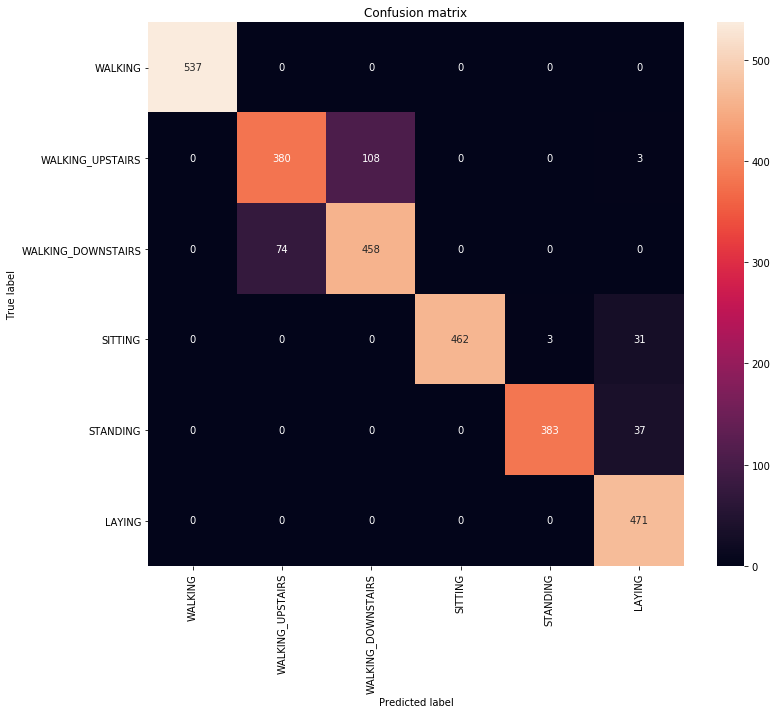

In [31]:
plot_confusion_matrix_lstm(Y_test, model.predict(X_test))

## 3 Layer LSTM with 96 initial nodes, Batch Normalization, Dropout Rate= 0.60,SoftMax Activation and 100 epochs

In [102]:
# Initiliazing the sequential model
from keras.layers.normalization import BatchNormalization
model = Sequential()
model.add(LSTM(96, input_shape=(timesteps, input_dim), return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.60))
model.add(LSTM(16))
model.add(BatchNormalization())
model.add(Dropout(0.60))

model.add(Dense(n_classes, activation='softmax'))
print("Model Summary: ")
model.summary()

Model Summary: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 128, 96)           40704     
_________________________________________________________________
batch_normalization_42 (Batc (None, 128, 96)           384       
_________________________________________________________________
dropout_42 (Dropout)         (None, 128, 96)           0         
_________________________________________________________________
lstm_49 (LSTM)               (None, 16)                7232      
_________________________________________________________________
batch_normalization_43 (Batc (None, 16)                64        
_________________________________________________________________
dropout_43 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 102  

In [103]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

In [106]:
# Training the model
trained_model=model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test), epochs=100)

Train on 7352 samples, validate on 2947 samples
Epoch 1/100
7352/7352 [==============================] - 66s 9ms/step - loss: 0.2125 - acc: 0.9260 - val_loss: 0.3751 - val_acc: 0.9226
Epoch 2/100
7352/7352 [==============================] - 65s 9ms/step - loss: 0.2440 - acc: 0.9196 - val_loss: 0.6634 - val_acc: 0.8772
Epoch 3/100
7352/7352 [==============================] - 65s 9ms/step - loss: 0.2096 - acc: 0.9221 - val_loss: 0.4519 - val_acc: 0.9141
Epoch 4/100
7352/7352 [==============================] - 65s 9ms/step - loss: 0.2103 - acc: 0.9237 - val_loss: 0.4149 - val_acc: 0.9128
Epoch 5/100
7352/7352 [==============================] - 66s 9ms/step - loss: 0.2075 - acc: 0.9255 - val_loss: 0.4424 - val_acc: 0.9162
Epoch 6/100
7352/7352 [==============================] - 65s 9ms/step - loss: 0.1965 - acc: 0.9272 - val_loss: 0.4882 - val_acc: 0.9199
Epoch 7/100
7352/7352 [==============================] - 65s 9ms/step - loss: 0.1964 - acc: 0.9229 - val_loss: 0.5520 - val_acc: 0.9053


7352/7352 [==============================] - 70s 9ms/step - loss: 0.2127 - acc: 0.9313 - val_loss: 0.3114 - val_acc: 0.9260
Epoch 61/100
7352/7352 [==============================] - 81s 11ms/step - loss: 0.2073 - acc: 0.9304 - val_loss: 0.3397 - val_acc: 0.9213
Epoch 62/100
7352/7352 [==============================] - 80s 11ms/step - loss: 0.1858 - acc: 0.9338 - val_loss: 0.4223 - val_acc: 0.9186
Epoch 63/100
7352/7352 [==============================] - 80s 11ms/step - loss: 0.1813 - acc: 0.9331 - val_loss: 0.3602 - val_acc: 0.9264
Epoch 64/100
7352/7352 [==============================] - 79s 11ms/step - loss: 0.2109 - acc: 0.9259 - val_loss: 0.4654 - val_acc: 0.9118
Epoch 65/100
7352/7352 [==============================] - 79s 11ms/step - loss: 0.5857 - acc: 0.8628 - val_loss: 0.3229 - val_acc: 0.9301
Epoch 66/100
7352/7352 [==============================] - 80s 11ms/step - loss: 0.2078 - acc: 0.9237 - val_loss: 0.4309 - val_acc: 0.9301
Epoch 67/100
7352/7352 [========================

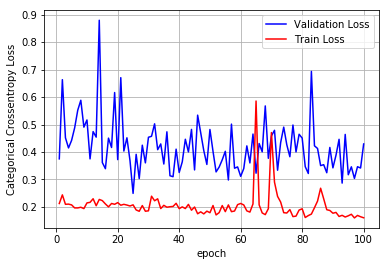

In [108]:
plot_train_cv_loss(trained_model, 100)

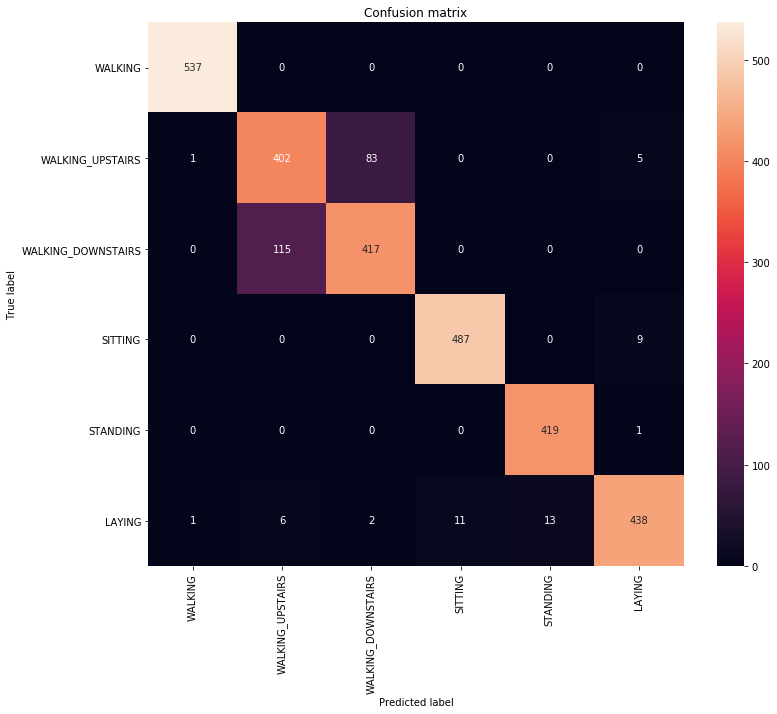

In [109]:
plot_confusion_matrix_lstm(Y_test, model.predict(X_test))

In [111]:
from prettytable import PrettyTable
ptable = PrettyTable()
ptable.title = " Model Comparision "
ptable.field_names = ["LSTM Layers",'No. of Neurons in LSTM Layer', 'Activation','Dropout', 'Best Epoch', 'Test Accuracy']
ptable.add_row([2, 32, 'Sigmoid', 0.5, 29, 90.67])
ptable.add_row([2, 32, 'SoftMax', 0.5, 27, 91.62])
ptable.add_row([2, 32, 'SoftMax', 0.7, 30, 91.41])
ptable.add_row([2, 64, 'SoftMax', 0.5, 22, 92.37])
ptable.add_row([2, 64, 'SoftMax', 0.7, 18, 91.65])
ptable.add_row([3, 32, 'SoftMax', 0.5, 25, 92.50])
ptable.add_row([3, 32, 'SoftMax', 0.7, 30, 90.57])
ptable.add_row([3, 64, 'SoftMax', 0.5, 20, 92.87])
ptable.add_row([3, 64, 'SoftMax', 0.7, 27, 92.43])
ptable.add_row([3, 96, 'SoftMax', 0.6, 93, 93.52])

print(ptable)

+-------------+------------------------------+------------+---------+------------+---------------+
| LSTM Layers | No. of Neurons in LSTM Layer | Activation | Dropout | Best Epoch | Test Accuracy |
+-------------+------------------------------+------------+---------+------------+---------------+
|      2      |              32              |  Sigmoid   |   0.5   |     29     |     90.67     |
|      2      |              32              |  SoftMax   |   0.5   |     27     |     91.62     |
|      2      |              32              |  SoftMax   |   0.7   |     30     |     91.41     |
|      2      |              64              |  SoftMax   |   0.5   |     22     |     92.37     |
|      2      |              64              |  SoftMax   |   0.7   |     18     |     91.65     |
|      3      |              32              |  SoftMax   |   0.5   |     25     |      92.5     |
|      3      |              32              |  SoftMax   |   0.7   |     30     |     90.57     |
|      3  

## From all the plots, we have observed that 96 neurons with 0.60 dropout rate and 93 epochs will be the good choice, among all the models
